In [ ]:
# install packages used in YOLO model
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
'''The program begins with a detailed comment outlining its purpose and objectives.
This implementation utilizes the YOLOv8 model, a state-of-the-art object detection algorithm, to address the critical issue of identifying riders who are not wearing helmets.
The model is trained on an extensive dataset containing images of riders with and without helmets, enabling it to accurately detect and classify such instances.
Once a helmetless rider is identified, the program further processes the image by zooming in on the license plate associated with the detected rider.
The license plate is then extracted for further actions, such as logging and enforcement, ensuring a comprehensive approach to improving road safety and compliance with helmet regulations.'''

In [ ]:
# check model
import ultralytics
ultralytics.checks()

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


In [ ]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet',
    '1': 'without helmet',
    '2': 'rider',
    '3': 'number_plate'
}
main_path = "/content/drive/MyDrive/Final_Year_Project/archive"

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



In [ ]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/content/drive/MyDrive/Final_Year_Project/archive"

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''

    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]

    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

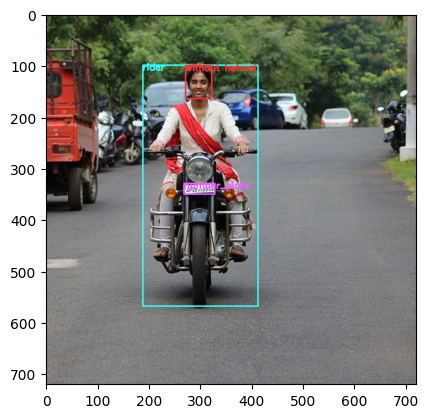

In [ ]:
plot_image(image_name='new50')

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 108MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [ ]:
# creata the yaml based on coco128 for model training
data = {
    'train': '/content/drive/MyDrive/Final_Year_Project/archive/train',
    'val': '/content/drive/MyDrive/Final_Year_Project/archive/val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('/content/drive/MyDrive/Final_Year_Project/archive/data.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('/content/drive/MyDrive/Final_Year_Project/archive/data.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
train: /content/drive/MyDrive/Final_Year_Project/archive/train
val: /content/drive/MyDrive/Final_Year_Project/archive/val



## Augmentation and Enhancement

In [ ]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
# Define augmentation settings in the training command
model.train(
    data='/content/drive/MyDrive/Final_Year_Project/archive/data.yaml',  # Path to your data.yaml file
    epochs=50,          # Number of epochs
    workers=2,          # Number of workers for data loading
    batch=8,            # Batch size
    imgsz=640,          # Image size for training
    augment=True,       # Enable augmentation
    hsv_h=0.015,        # Adjust hue (default: 0.015)
    hsv_s=0.7,          # Adjust saturation (default: 0.7)
    hsv_v=0.4,          # Adjust value (default: 0.4)
    degrees=0.0,        # Image rotation degrees (default: 0.0)
    translate=0.1,      # Image translation fraction (default: 0.1)
    scale=0.5,          # Image scaling fraction (default: 0.5)
    shear=0.0,          # Image shearing degrees (default: 0.0)
    perspective=0.0,    # Perspective warping fraction (default: 0.0)
    flipud=0.0,         # Vertical flip probability (default: 0.0)
    fliplr=0.5          # Horizontal flip probability (default: 0.5)
)

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Final_Year_Project/archive/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.2MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Final_Year_Project/archive/train/labels.cache... 102 images, 32 backgrounds, 2 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Final_Year_Project/archive/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Final_Year_Project/archive/train/images/new128.jpg'
train: WARNING ⚠️ /content/drive/MyDrive/Final_Year_Project/archive/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'jpeg', 'tif', 'png', 'heic', 'pfm', 'webp', 'tiff', 'dng', 'jpg', 'mpo', 'bmp'}
videos: {'webm', 'asf', 'gif', 'mov', 'avi', 'mkv', 'm4v', 'mp4', 'mpg', 'ts', 'wmv', 'mpeg'}


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Final_Year_Project/archive/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       1.2G     0.9476       3.39      1.224         38        640: 100%|██████████| 17/17 [00:25<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

                   all         20         73     0.0191      0.342       0.21      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.18G     0.9308      2.115      1.159         38        640: 100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         20         73     0.0407      0.682      0.361       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.18G     0.9185      1.588      1.122         47        640: 100%|██████████| 17/17 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


                   all         20         73      0.908      0.228      0.723      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.18G     0.9108      1.471      1.126         41        640: 100%|██████████| 17/17 [00:03<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         20         73      0.799      0.461       0.77      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.2G     0.8785      1.374        1.1         54        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         20         73      0.811      0.683      0.841      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.18G     0.8884      1.283      1.087         31        640: 100%|██████████| 17/17 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         20         73      0.807      0.709      0.866       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.18G     0.8844      1.183       1.08         31        640: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         20         73       0.79      0.696      0.847      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.18G     0.8825      1.176       1.11         16        640: 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


                   all         20         73      0.782      0.776       0.87      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.18G     0.8674      1.133      1.093         32        640: 100%|██████████| 17/17 [00:03<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         20         73       0.89      0.744      0.899      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.18G     0.8567      1.072       1.07         32        640: 100%|██████████| 17/17 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


                   all         20         73      0.888      0.815      0.901      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.18G     0.8527      1.066      1.097         39        640: 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         20         73      0.862        0.8      0.878      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.18G     0.7692     0.9856      1.044         33        640: 100%|██████████| 17/17 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         20         73      0.861      0.774      0.866      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.18G     0.8211      1.019      1.047         79        640: 100%|██████████| 17/17 [00:03<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         20         73      0.871      0.836      0.919      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.18G     0.8167     0.9549      1.038         40        640: 100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         20         73      0.954        0.8      0.914      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.18G     0.8118     0.9587      1.047         46        640: 100%|██████████| 17/17 [00:03<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


                   all         20         73      0.938      0.822       0.92      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.18G     0.7831     0.9385      1.023         30        640: 100%|██████████| 17/17 [00:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


                   all         20         73      0.848      0.906      0.925      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.18G     0.8169     0.9845      1.081         17        640: 100%|██████████| 17/17 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         20         73       0.87      0.884       0.92      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.18G     0.7593     0.8981      1.036         22        640: 100%|██████████| 17/17 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         20         73      0.862       0.87       0.91      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.18G     0.7892     0.9083      1.033         37        640: 100%|██████████| 17/17 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         20         73      0.897      0.882       0.94      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.18G     0.7181      0.878      1.009         43        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         20         73      0.882      0.915      0.932      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.18G     0.7736     0.8723      1.024         36        640: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         20         73      0.841       0.88       0.93       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.18G     0.7091     0.8027     0.9982         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         20         73      0.864      0.891      0.931      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.18G     0.7153      0.831      1.017         42        640: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         20         73      0.895      0.902      0.929      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.18G     0.7754     0.8545      1.016         33        640: 100%|██████████| 17/17 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         20         73      0.912      0.915       0.92      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.18G     0.6971      0.794      1.002         34        640: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

                   all         20         73      0.948      0.901       0.93      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.18G     0.6952      0.768      1.001         34        640: 100%|██████████| 17/17 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         20         73      0.936      0.908      0.927      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.18G      0.674     0.7696     0.9748         35        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         20         73      0.933      0.895      0.917      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.14G     0.6437     0.7226     0.9665         30        640: 100%|██████████| 17/17 [00:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         20         73       0.94      0.866      0.915      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.18G     0.6524     0.7364     0.9739         29        640: 100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         20         73      0.931      0.894       0.92      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.18G     0.6846     0.8216      1.031         33        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         20         73      0.897      0.917      0.921       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.14G     0.6808     0.7774      1.001         16        640: 100%|██████████| 17/17 [00:03<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


                   all         20         73      0.922       0.89      0.924      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.18G     0.6399     0.7012     0.9758         23        640: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         20         73      0.935      0.903      0.926      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.18G     0.6389     0.6776     0.9679         42        640: 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         20         73      0.942       0.89      0.929      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.18G     0.6413     0.6987     0.9752         23        640: 100%|██████████| 17/17 [00:03<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         20         73       0.94      0.874       0.93      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.14G     0.6092     0.6561     0.9475         31        640: 100%|██████████| 17/17 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         20         73      0.953      0.893      0.935      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.18G     0.6129     0.6454     0.9629         56        640: 100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         20         73      0.945      0.888      0.935      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.18G     0.5769      0.647      0.953         52        640: 100%|██████████| 17/17 [00:03<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                   all         20         73      0.948      0.887      0.933      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       1.2G     0.5753     0.6277     0.9525         35        640: 100%|██████████| 17/17 [00:03<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         20         73      0.954      0.887      0.929      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       1.2G      0.598     0.6315     0.9535         36        640: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


                   all         20         73      0.946      0.925      0.932      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.18G     0.5627     0.6354     0.9513         28        640: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         20         73      0.949      0.919      0.932      0.759


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.18G     0.5887      0.837      0.929         14        640: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         20         73       0.95      0.916       0.93      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.18G     0.5625     0.7941     0.9113         26        640: 100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         20         73      0.928      0.912      0.929      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.18G     0.5518     0.7303     0.9118         11        640: 100%|██████████| 17/17 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         20         73      0.934      0.895      0.929      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.18G      0.524     0.7206     0.8956         13        640: 100%|██████████| 17/17 [00:03<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         20         73      0.942      0.893      0.932      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.18G     0.5154      0.711     0.8919         23        640: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         20         73      0.946      0.893      0.934      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.18G     0.5115     0.6658     0.8818         16        640: 100%|██████████| 17/17 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         20         73      0.948      0.891      0.935      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.18G     0.5147     0.6657     0.8753         16        640: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


                   all         20         73       0.95      0.887      0.935      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.18G     0.5051     0.6778     0.8917         21        640: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         20         73      0.949      0.886      0.933      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.18G     0.4841     0.6499     0.8747         13        640: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         20         73      0.952      0.885      0.936      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.18G     0.5032     0.6496     0.8781         15        640: 100%|██████████| 17/17 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         20         73      0.943      0.905      0.937      0.757



50 epochs completed in 0.091 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


                   all         20         73      0.921      0.861      0.936      0.795
           with helmet         12         13      0.968      0.769      0.907      0.763
        without helmet         10         15      0.752      0.808      0.918      0.745
                 rider         20         23      0.967      0.913      0.936      0.863
          number plate         20         22      0.996      0.955      0.984       0.81
Speed: 0.2ms preprocess, 58.8ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dac88a747c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
# Evaluate the model on validation data
metrics = model.val(
    data='/content/drive/MyDrive/Final_Year_Project/archive/data.yaml',  # Path to the data.yaml file
    split='val'  # Specify the validation split
)

# Extract relevant speed metrics
inference_time = metrics.speed['inference']  # Time per image for inference in milliseconds

# Calculate FPS
fps = 1000 / inference_time if inference_time else 0

# Print the metrics
print("\nModel Validation Metrics:")
print(f"Precision: {metrics.box.map50:.4f}")  # Precision for mAP@0.5
print(f"Recall: {metrics.box.map:.4f}")       # Recall for mAP@0.5:0.95
print(f"Mean Average Precision (mAP@0.5): {metrics.box.map50:.4f}")
print(f"Mean Average Precision (mAP@0.5:0.95): {metrics.box.map:.4f}")
print(f"Inference Speed (FPS): {fps:.2f}")

# Class-wise precision, recall, and mAP
for i, class_name in enumerate(metrics.names):
    precision, recall, mAP50, mAP50_95 = metrics.class_result(i)
    print(f"{class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  mAP50: {mAP50:.4f}")
    print(f"  mAP50-95: {mAP50_95:.4f}")


Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Final_Year_Project/archive/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


                   all         20         73      0.916      0.895      0.944       0.79
           with helmet         12         13          1      0.838      0.914      0.764
        without helmet         10         15      0.766      0.875      0.922       0.74
                 rider         20         23      0.918      0.913      0.958      0.866
          number plate         20         22      0.979      0.955      0.984      0.788
Speed: 0.3ms preprocess, 65.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train2

Model Validation Metrics:
Precision: 0.9445
Recall: 0.7896
Mean Average Precision (mAP@0.5): 0.9445
Mean Average Precision (mAP@0.5:0.95): 0.7896
Inference Speed (FPS): 15.38
0:
  Precision: 1.0000
  Recall: 0.8383
  mAP50: 0.9138
  mAP50-95: 0.7638
1:
  Precision: 0.7664
  Recall: 0.8755
  mAP50: 0.9221
  mAP50-95: 0.7404
2:
  Precision: 0.9179
  Recall: 0.9130
  mAP50: 0.9575
  mAP50-95: 0.8660
3:
  Precision: 0.9791
  Recall: 0.

In [ ]:
# select the best model for checking prediction plot
# the model is saved in best.pt directly after training
model = YOLO('/content/runs/detect/train/weights/best.pt')


In [ ]:
# use results from `model.predict()` for plotting
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

prediction ↓

image 1/1 /content/drive/MyDrive/Final_Year_Project/archive/val/images/new94.jpg: 608x640 1 with helmet, 1 rider, 1 number plate, 35.5ms
Speed: 2.7ms preprocess, 35.5ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


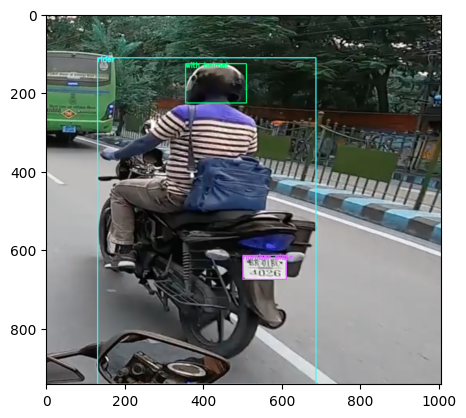

actual image ↓


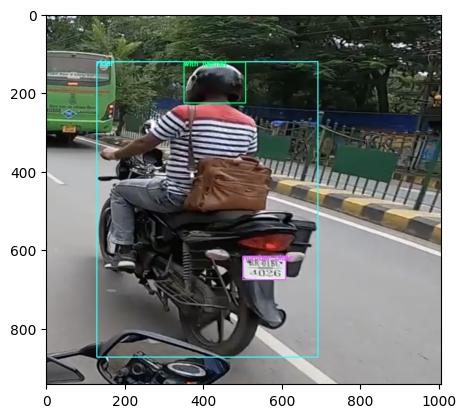

In [ ]:
image_name = 'new94'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='val')

In [ ]:
# Evaluate the model on validation data
metrics = model.val(
    data='/content/drive/MyDrive/Final_Year_Project/archive/data.yaml',  # Path to the data.yaml file
    split='val'                        # Specify the validation split
)

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/Final_Year_Project/archive/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         20         73      0.953      0.893      0.935      0.771
           with helmet         12         13          1      0.843      0.919       0.74
        without helmet         10         15      0.866      0.864      0.907      0.747
                 rider         20         23      0.945      0.913      0.923      0.804
          number plate         20         22          1       0.95      0.992      0.794
Speed: 0.2ms preprocess, 6.7ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val



image 1/1 /content/drive/MyDrive/Final_Year_Project/archive/val/images/new94.jpg: 608x640 1 with helmet, 1 rider, 1 number plate, 10.5ms
Speed: 3.9ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


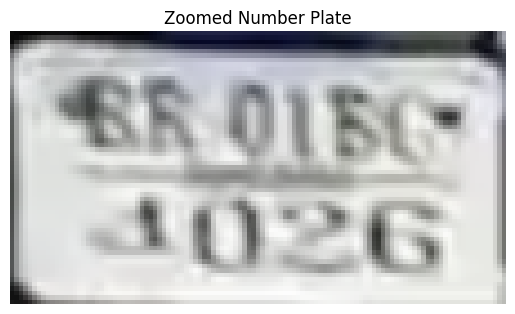

In [ ]:
def plot_zoomed_number_plate_validation_images(image_name, id2class_map=id2class_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')

    # Get predictions
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]

    # Find the bounding box for the number plate
    for bbox, label in zip(bboxes, labels):
        if label == 'number_plate':
            x_min, y_min, x_max, y_max = [int(n) for n in bbox]
            cropped_img = img[y_min:y_max, x_min:x_max]
            plt.imshow(cropped_img)
            plt.title("Zoomed Number Plate")
            plt.axis('off')
            plt.show()
            return

    print("No number plate detected in the image.")

# Test the function
plot_zoomed_number_plate_validation_images(image_name='new94')


Prediction for new0:

image 1/1 /content/drive/MyDrive/Final_Year_Project/archive/val/images/new0.jpg: 640x576 2 without helmets, 1 rider, 1 number plate, 54.8ms
Speed: 4.1ms preprocess, 54.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)


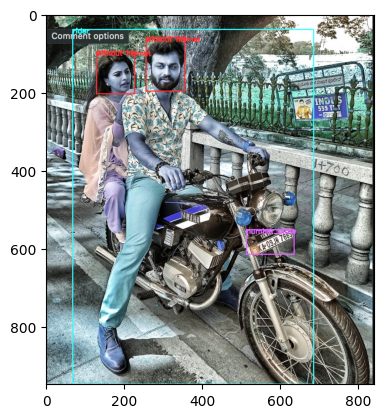

In [ ]:
# Specify the new image name
image_name = 'new0'  # Replace 'new200' with the name of your image without the extension

# Call the function with the new image
print(f'Prediction for {image_name}:')
plot_pred_image(image_name=image_name)



image 1/1 /content/drive/MyDrive/Final_Year_Project/archive/val/images/new0.jpg: 640x576 2 without helmets, 1 rider, 1 number plate, 10.0ms
Speed: 4.2ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


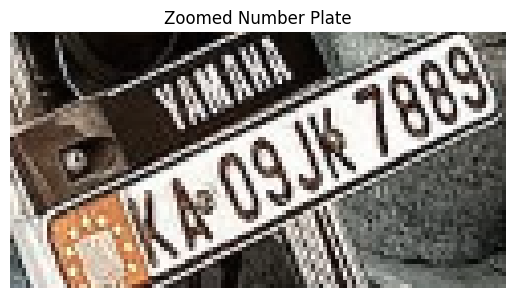

In [ ]:
plot_zoomed_number_plate_validation_images(image_name='new0')

## Predict on unseen image

In [ ]:
# Load the trained model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Path to your trained model


In [ ]:
# Path to the directory containing images
image_directory = ""  # Replace with your directory path

In [ ]:
# Class and color mappings
id2class_map = {
    '0': 'with helmet',
    '1': 'without helmet',
    '2': 'rider',
    '3': 'number_plate'
}
class2color_map = {
    'with helmet': (0, 255, 128),
    'without helmet': (255, 51, 51),
    'rider': (51, 255, 255),
    'number_plate': (224, 102, 255)
}


In [ ]:
# Function to plot full image with detections
def plot_full_image(image_path, model, id2class_map, class2color_map):
    # Predict on the image
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]

    # Draw bounding boxes on the full image
    for bbox, label in zip(bboxes, labels):
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # Draw bounding box
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)

        # Add label text
        img = cv2.putText(
            img,
            label,
            (x_min, y_min - 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.6,
            color=color,
            thickness=2
        )

    # Display full image with detections
    plt.imshow(img)
    plt.title("Full Image with Detections")
    plt.axis('off')
    plt.show()

    return r

In [ ]:
# Function to plot zoomed license plate
def plot_zoomed_license_plate(results, id2class_map):
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]

    # Find and zoom on the license plate
    for bbox, label in zip(bboxes, labels):
        if label == 'number_plate':
            x_min, y_min, x_max, y_max = [int(n) for n in bbox]
            cropped_img = img[y_min:y_max, x_min:x_max]

            # Display the zoomed license plate
            plt.imshow(cropped_img)
            plt.title("Zoomed License Plate")
            plt.axis('off')
            plt.show()
            return

    print("No license plate detected in the image.")

In [ ]:
# Specify the image file (replace 'image.jpg' with your file name)
image_name = "/content/test5.jpeg"  # Replace with your image file
image_path = os.path.join(image_directory, image_name)


image 1/1 /content/test5.jpeg: 640x640 3 with helmets, 1 without helmet, 2 riders, 3 number plates, 79.4ms
Speed: 31.3ms preprocess, 79.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test5.jpeg: 640x640 3 with helmets, 1 without helmet, 2 riders, 3 number plates, 28.6ms
Speed: 11.7ms preprocess, 28.6ms inference, 24.4ms postprocess per image at shape (1, 3, 640, 640)


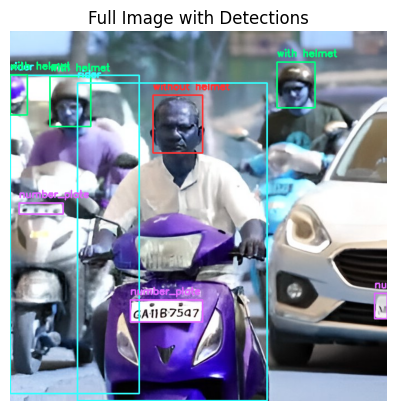

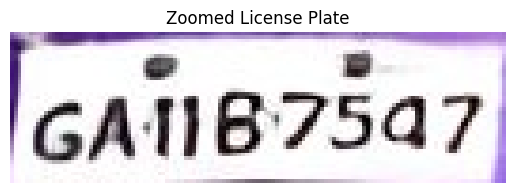

In [ ]:
# Display full image and zoomed license plate
results = model.predict(image_path)  # Predict once and reuse the results
plot_full_image(image_path, model, id2class_map, class2color_map)
plot_zoomed_license_plate(results, id2class_map)

## Extracting numbers

In [ ]:
#converting to UTF-8

import locale
print(locale.getpreferredencoding())

ANSI_X3.4-1968


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
pip install easyocr

In [ ]:
import easyocr
import matplotlib.pyplot as plt
import cv2
import os


In [ ]:
# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# Function to detect text in the cropped number plate
def detect_text_in_number_plate(cropped_img):
    # Perform OCR on the cropped image
    result = reader.readtext(cropped_img)

    # Extract and print the text
    detected_text = " ".join([res[1] for res in result])
    print("Detected Text on Number Plate:", detected_text)

    # Display the cropped number plate
    plt.imshow(cropped_img)
    plt.title(f"Detected Text: {detected_text}")
    plt.axis('off')
    plt.show()

In [ ]:
def detect_number_plate_text(image_path, model, id2class_map):
    # Predict on the input image
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]

    # Find and process the number plate
    for bbox, label in zip(bboxes, labels):
        if label == 'number_plate':
            x_min, y_min, x_max, y_max = [int(n) for n in bbox]
            cropped_img = img[y_min:y_max, x_min:x_max]

            # Detect text in the cropped number plate
            detect_text_in_number_plate(cropped_img)
            return

    print("No number plate detected in the image.")


image 1/1 /content/test5_enhanced_2.jpeg: 640x640 3 with helmets, 3 without helmets, 2 riders, 2 number plates, 40.1ms
Speed: 18.2ms preprocess, 40.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Detected Text on Number Plate: GAII875a7


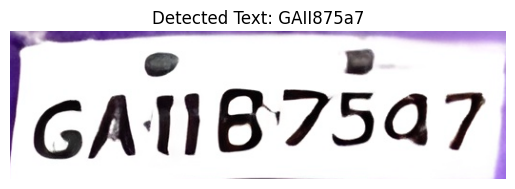

In [ ]:
# Specify the image file
image_name = "test5_enhanced_2.jpeg"  # Replace with your image file
image_path = os.path.join(image_directory, image_name)

# Detect and extract text from the number plate
detect_number_plate_text(image_path, model, id2class_map)